# Notas



Pipeline sugerido: <br>
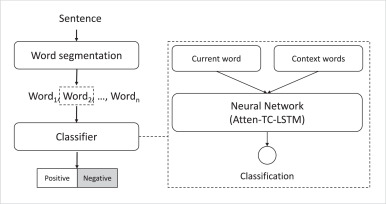

Fuente: https://reader.elsevier.com/reader/sd/pii/S092523121931687X?token=FC73D0A2D97F651107829FA32607FEB1805FAEC2511A5EE011CEBD5C1E56D90AD074665F19F578230F696CD46DB25CA2&originRegion=eu-west-1&originCreation=20230307084138

In [1]:
import os.path
import requests
from shutil import unpack_archive

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

2023-03-28 15:28:19.459212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 15:28:19.606895: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-28 15:28:19.610270: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2023-03-28 15:28:19.610285: I tensorflow/compiler/xla/stream_executor/cuda/cudart_

# Preprocesamiento muy inicial de los datos

In [2]:
# datos preparados
url_datos_moodle = "https://gist.githubusercontent.com/w-dan/b84bdbfbd86b610a89aa0aa57e6efb5e/raw/aeaffaa9d26c66678b697ecb9fd99fd0c8eaca52/papers.csv"

In [3]:
df = pd.read_csv(url_datos_moodle)
df

,id,title,abstract,Unnamed: 3,keywords,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,1,Ensemble Statistical and Heuristic Models for ...,Statistical word alignment models need large a...,NaN,"statistical word alignment, ensemble learning,...",NaN,NaN,NaN
1,2,Improving Spectral Learning by Using Multiple ...,Spectral learning algorithms learn an unknown ...,NaN,"representation, spectral learning, discrete fo...",NaN,NaN,NaN
2,3,Applying Swarm Ensemble Clustering Technique f...,Number of defects remaining in a system provid...,NaN,"software defect prediction, particle swarm opt...",NaN,NaN,NaN
3,4,Reducing the Effects of Detrimental Instances,Not all instances in a data set are equally be...,NaN,"filtering, label noise, instance weighting",NaN,NaN,NaN
4,5,Concept Drift Awareness in Twitter Streams,Learning in non-stationary environments is not...,NaN,"twitter, adaptation models, time-frequency ana...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
443,444,A Machine Learning Tool for Supporting Advance...,"In the current era of big data, high volumes o...",NaN,"machine-learning,unsupervised-learning,knowled...",NaN,NaN,NaN
444,445,Advanced ECHMM-Based Machine Learning Tools fo...,We present a novel approach for accurate chara...,NaN,"workload characterization,hmm,cepstral coeffic...",NaN,NaN,NaN
445,446,A Cluster Analysis of Challenging Behaviors in...,"We apply cluster analysis to a sample of 2,116...",NaN,"cluster analysis,autism spectrum disorder,chal...",NaN,NaN,NaN
446,447,Predicting Psychosis Using the Experience Samp...,Smart phones have become ubiquitous in the rec...,NaN,"predicting psychosis,esm,mhealth,svm,gaussian ...",NaN,NaN,NaN


Separación de variable objetivo y demás atributos

In [4]:
y = df['keywords']
X = df.drop(['keywords'], axis=1)

Comprobamos las columnas Unnamed, tienen muchos valores NaN y parecen raras

In [5]:
print("El dataset tiene ", len(df), " filas")

print("===== NULOS =====")
df.isnull().sum()

El dataset tiene  448  filas
===== NULOS =====


id              0
title           0
abstract        0
Unnamed: 3    448
keywords        0
Unnamed: 5    443
Unnamed: 6    444
Unnamed: 7    447
dtype: int64

In [6]:
X = X.drop(['id', 'Unnamed: 3', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7'], axis=1)
X

,title,abstract
0,Ensemble Statistical and Heuristic Models for ...,Statistical word alignment models need large a...
1,Improving Spectral Learning by Using Multiple ...,Spectral learning algorithms learn an unknown ...
2,Applying Swarm Ensemble Clustering Technique f...,Number of defects remaining in a system provid...
3,Reducing the Effects of Detrimental Instances,Not all instances in a data set are equally be...
4,Concept Drift Awareness in Twitter Streams,Learning in non-stationary environments is not...
...,...,...
443,A Machine Learning Tool for Supporting Advance...,"In the current era of big data, high volumes o..."
444,Advanced ECHMM-Based Machine Learning Tools fo...,We present a novel approach for accurate chara...
445,A Cluster Analysis of Challenging Behaviors in...,"We apply cluster analysis to a sample of 2,116..."
446,Predicting Psychosis Using the Experience Samp...,Smart phones have become ubiquitous in the rec...


In [7]:
y = pd.DataFrame(y, columns=['keywords'])
y

,keywords
0,"statistical word alignment, ensemble learning,..."
1,"representation, spectral learning, discrete fo..."
2,"software defect prediction, particle swarm opt..."
3,"filtering, label noise, instance weighting"
4,"twitter, adaptation models, time-frequency ana..."
...,...
443,"machine-learning,unsupervised-learning,knowled..."
444,"workload characterization,hmm,cepstral coeffic..."
445,"cluster analysis,autism spectrum disorder,chal..."
446,"predicting psychosis,esm,mhealth,svm,gaussian ..."


Hacer un bag of words con estos abstracts produciría una segmentación demencial que nos haría perder el hilo, aunque aún es pronto para descartarlo. Podemos emplear alguna técnica de [word embedding](https://es.wikipedia.org/wiki/Word_embedding):

# Entrenamiento de word embedding con GLoVe

Vamos a entrenar una capa de word embedding con el conjunto de datos de Stanford:

In [8]:
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (16, 9),'figure.dpi': 100})

tf.compat.v1.disable_eager_execution()  # Esto es por un problema (creo) con las RTX2070

In [9]:
GLOVE_URL = 'http://nlp.stanford.edu/data/glove.6B.zip'
GLOVE_FILE = 'glove.6B.zip'
GLOVE_DIR = 'glove'

if not os.path.isdir(GLOVE_DIR):
    # Descargamos el dataset comprimido de GloVe (si no lo tenemos ya)
    if not os.path.exists(GLOVE_FILE):
        with open(GLOVE_FILE, 'wb') as f:
            r = requests.get(GLOVE_URL, allow_redirects=True)
            f.write(r.content)
    # Lo descomprimimos en el directorio 'glove'
    unpack_archive(GLOVE_FILE, 'glove/')

Establecemos parámetros

In [10]:
lens = [len(s) for s in X['abstract']]

lens = pd.DataFrame(lens)


Establecemos MAX_SEQUENCE_LENGTH a la mediana de las longitudes de los abstracts, de aproximadamente 986 palabras.

In [11]:
# Dimensiones de los word vectors (50, 100, 200 o 300)
EMBEDDING_DIM = 50
# Tamaño máximo de nuestro vocabulario (se escogerán las más frecuentes)
MAX_VOCAB_SIZE = 10000
# El tamaño de la frase más larga con la que alimentar el modelo
MAX_SEQUENCE_LENGTH = int(lens.median())

In [12]:
del lens

We load the Embedding of the dimension specified in the configuration

In [13]:
print(f'Loading GloVe {EMBEDDING_DIM}-d embedding... ', end='')
word2vec = {}
with open(os.path.join(GLOVE_DIR, f'glove.6B.{EMBEDDING_DIM}d.txt')) as f:
    for line in f:
        values = line.split()
        word2vec[values[0]] = np.asarray(values[1:], dtype='float32')
print(f'done ({len(word2vec)} word vectors loaded)')

Loading GloVe 50-d embedding... done (400000 word vectors loaded)


In [14]:
print('Loading training articles dataset... ', end='')

targets = y.values[:,0]
abstracts = X.values[:,1]
titles = X.values[:,0]

print(f'done ({len(y)} abstracts loaded)')
print(f'Biggest abstract length:  {max(len(s) for s in abstracts)}')
print(f'Smallest abstract length: {min(len(s) for s in abstracts)}')
print(f'Avg. abstract length:     {np.mean([len(s) for s in abstracts])}')
# print(f'Median abstract length:   {sorted(len(s) for s in X)[len(X) // 2]}')
print('-' * 20)
print(f'Example abstract: {X.iloc[9]}')
print(f'Example keywords: {targets[9]}')

Loading training articles dataset... done (448 abstracts loaded)
Biggest abstract length:  2008
Smallest abstract length: 10
Avg. abstract length:     1038.9441964285713
--------------------
Example abstract: title       Detection of abnormal human behavior using a m...
abstract    Automatic detection of abnormal events is one ...
Name: 9, dtype: object
Example keywords: abnormal event detection, low-rank approximation, adaptive learning


## Tokenize and add Padding

1. Abstracts
2. Keywords

In [15]:
from utils import tokenize_and_add_padding

In [16]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB_SIZE)

In [17]:
y_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB_SIZE)

In [18]:
sequences, word_index, data = tokenize_and_add_padding(abstracts, tokenizer, MAX_SEQUENCE_LENGTH)

In [19]:
len(data[400])

985

In [20]:
targets[1]

'representation, spectral learning, discrete fourier, basis selection, ensemble'

In [21]:
targets = [k.split(',') for k in targets]

In [22]:
max_len = sorted(len(target) for target in targets)[-1]

In [23]:
y_sequences, y_word_index, y_data = tokenize_and_add_padding(targets, y_tokenizer, max_len)

In [24]:
OUTPUT_SIZE = len(y_word_index.keys())
OUTPUT_SIZE

1616

In [25]:
targets[440]

['big data', 'gpu computing', 'machine learning', 'gpgpu']

In [26]:
k = list(y_word_index.keys())
k[21]

'big data'

In [27]:
y_data[440]

array([   0,    0,    0,    0,    0,    0,    0,   22, 1595,    1, 1596],
      dtype=int32)

In [28]:
one_hot_tokenized = []

for i in range(len(y_data)):
    one_hot_tokenized.append(np.zeros(OUTPUT_SIZE+1))
    for t in y_data[i]:
        one_hot_tokenized[i][t] = 1

one_hot_tokenized = np.asarray(one_hot_tokenized)

# CNN model

## Embedding layer

In [29]:
print('Loading embedding with GloVe vectors... ', end='')
# Cargamos sólo las palabras elegidas de nuestro conjunto de datos
num_words = min(MAX_VOCAB_SIZE, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Creamos la capa de embedding
embedding_layer = tf.keras.layers.Embedding(
  input_dim=num_words,
  output_dim=EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False,
)
print('done')

Loading embedding with GloVe vectors... done


In [30]:
input_ = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = tf.keras.layers.Conv1D(16, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(8, activation='relu')(x)
output = tf.keras.layers.Dense(OUTPUT_SIZE+1, activation='linear')(x)

model = tf.keras.Model(input_, output)
model.compile(
    loss='MSE',
    optimizer='adam',
    metrics=['accuracy'],
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 985)]             0         
                                                                 
 embedding (Embedding)       (None, 985, 50)           332650    
                                                                 
 conv1d (Conv1D)             (None, 983, 16)           2416      
                                                                 
 flatten (Flatten)           (None, 15728)             0         
                                                                 
 dense (Dense)               (None, 1617)              25433793  
                                                                 
Total params: 25,768,859
Trainable params: 25,436,209
Non-trainable params: 332,650
_________________________________________________________________


2023-03-28 15:28:27.206849: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2023-03-28 15:28:27.206877: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-28 15:28:27.206900: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2023-03-28 15:28:27.207251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 15:28:27.209763: I tensorfl

In [31]:
model.output_shape

(None, 1617)

In [32]:
one_hot_tokenized.shape

(448, 1617)

In [33]:
checkpoint_filepath = './checkpoints'

In [34]:
# create checkpoint
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [35]:
# TODO : Model does not predict correctly. It only predicts 'machine learning' for every abstract with acc > 0.5 (see testing down)
history = model.fit(data, one_hot_tokenized, epochs=10, validation_split=0.15)  # callbacks=[model_checkpoint_callback]

Train on 380 samples, validate on 68 samples


2023-03-28 15:28:27.587394: W tensorflow/c/c_api.cc:291] Operation '{name:'training/Adam/dense/bias/m/Assign' id:265 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense/bias/m, training/Adam/dense/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/10
380/380 [==============================] - 2s 5ms/sample - loss: 0.2446 - accuracy: 0.4132 - val_loss: 0.1218 - val_accuracy: 0.9412
Epoch 2/10


/home/b1111y/Documents/AgentesApuntes/practicas/AgentesInteligentes/env/lib/python3.10/site-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-03-28 15:28:29.777513: W tensorflow/c/c_api.cc:291] Operation '{name:'loss/mul' id:128 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


380/380 [==============================] - 1s 4ms/sample - loss: 0.0645 - accuracy: 0.7395 - val_loss: 0.0401 - val_accuracy: 0.9706
Epoch 3/10
380/380 [==============================] - 1s 4ms/sample - loss: 0.0309 - accuracy: 0.9789 - val_loss: 0.0314 - val_accuracy: 0.9706
Epoch 4/10
380/380 [==============================] - 2s 4ms/sample - loss: 0.0185 - accuracy: 0.9658 - val_loss: 0.0248 - val_accuracy: 1.0000
Epoch 5/10
380/380 [==============================] - 1s 4ms/sample - loss: 0.0125 - accuracy: 0.9684 - val_loss: 0.0216 - val_accuracy: 1.0000
Epoch 6/10
380/380 [==============================] - 1s 4ms/sample - loss: 0.0094 - accuracy: 0.9737 - val_loss: 0.0204 - val_accuracy: 1.0000
Epoch 7/10
380/380 [==============================] - 2s 4ms/sample - loss: 0.0075 - accuracy: 0.9789 - val_loss: 0.0195 - val_accuracy: 1.0000
Epoch 8/10
380/380 [==============================] - 1s 4ms/sample - loss: 0.0061 - accuracy: 0.9868 - val_loss: 0.0190 - val_accuracy: 1.0000
Epo

## Plot this shitty history XD

In [36]:
from utils import plot_history

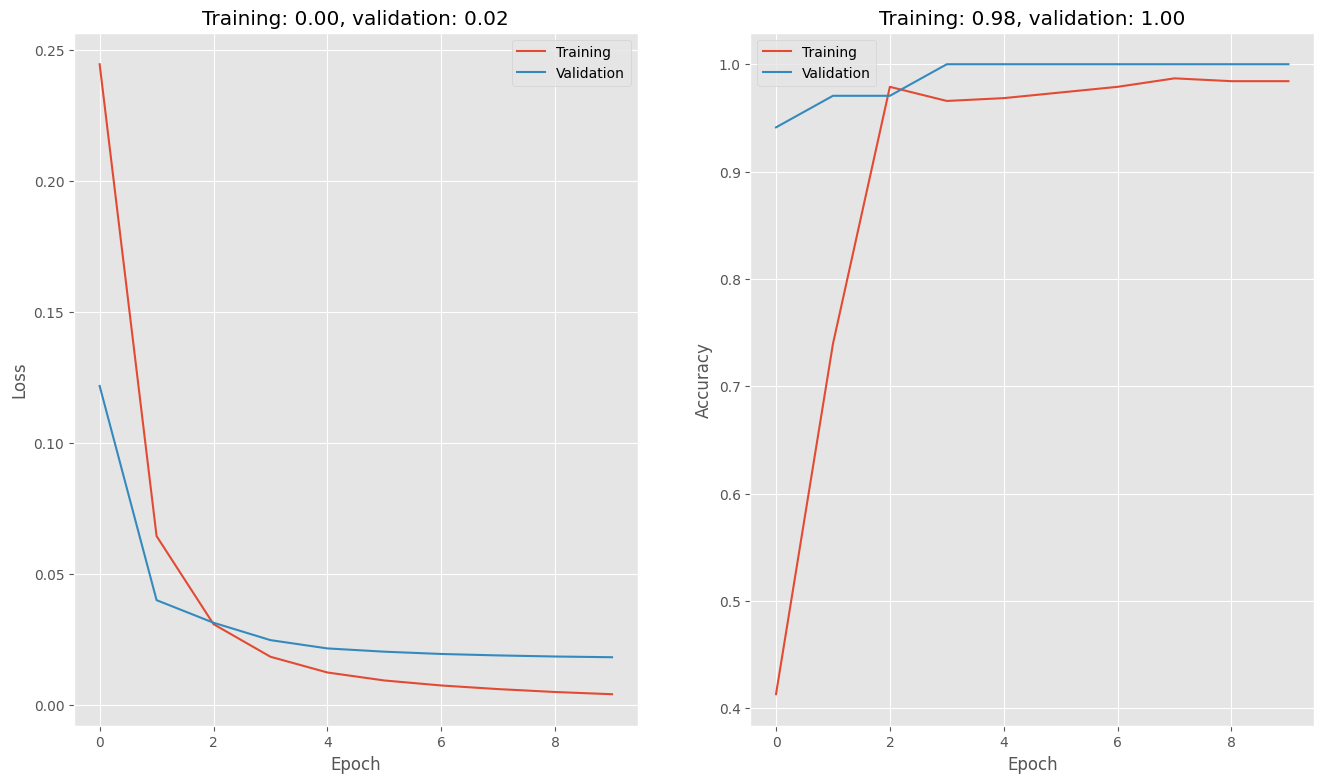

In [37]:
plot_history(history)

### Test set

In [38]:
abstracts[200]

'Despite an abundance of commands to make tasks easier to perform, the users of feature-rich applications, such as development environments, use only a fraction of the commands available. Earlier work has shown that command recommendation -- in which, given the command usage history of a set of users, the objective is to predict a command that is likely useful for the user to learn -- can improve the usage of a range of commands available within such applications. In this paper, we present a new algorithm, CoDis, which is built upon three hypotheses. First, we hypothesize that in feature-rich applications there exists co-occurrence patterns between commands. Second, we hypothesize that users of feature-rich applications have prevalent discovery patterns. Finally, we hypothesize that users need different recommendations based on the time elapsed between their last activity and the time of recommendation. We show on data submitted by many users of an integrated development environment (E

In [39]:
_, _, test_data = tokenize_and_add_padding([abstracts[440], abstracts[200]], tokenizer, MAX_SEQUENCE_LENGTH)

In [40]:
y_hat = model.predict(test_data)

/home/b1111y/Documents/AgentesApuntes/practicas/AgentesInteligentes/env/lib/python3.10/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-03-28 15:28:44.070318: W tensorflow/c/c_api.cc:291] Operation '{name:'dense/BiasAdd' id:81 op device:{requested: '', assigned: ''} def:{{{node dense/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense/MatMul, dense/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [41]:
keys = []

for i, prediction in enumerate(y_hat):
    keys.append([])
    for j, key in enumerate(prediction):
        if key >= 0.5:
            keys[i].append(k[j])

keys

[['machine learning'], ['machine learning']]

In [42]:
targets[440]

['big data', 'gpu computing', 'machine learning', 'gpgpu']

In [43]:
targets[200]

['collaboration',
 'history',
 'recommender systems',
 'software',
 'documentation',
 'computational modeling',
 'computer science']

# RNN model

In [44]:
# XD
